**EDA + SEGMENTASI PELANGGAN pada E-Commerce**

Membantu merancang strategi prusahaan yang efektif dan efisien dengan membagi segmentasi pelanggan dan menganalisis data penjualan E-Commerce yang didasarkan pada perilaku pembelian mereka.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from operator import attrgetter
import datetime as dt
import matplotlib.colors as mcolors
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
data=pd.read_csv('data.csv', encoding= 'unicode_escape')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Data Cleaning

In [5]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Karena ID pelanggan sangat dibutuhkan dan kami tidak memiliki cara yang dapat diandalkan untuk mengganti deskripsi, kami akan membuang poin data yang memiliki NaN di keduanya

In [7]:
data.dropna(subset=['CustomerID'], inplace=True)

In [8]:
data.dropna(subset=['Description'], inplace=True)

In [9]:
data.shape

(406829, 8)

## EDA

Pertanyaan yang harus dijawab

T- Berapa jumlah rata-rata barang yang dipesan secara keseluruhan?

T- Berapa harga satuan rata-rata dari setiap item

In [10]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.0,13953.00,15152.00,16791.00,18287.0


Ans1- 12 approx.

Ans2- 3.5

Dari tabel di atas, dapat dilihat bahwa ada pesanan dengan kuantitas negatif - kemungkinan besar pengembalian

Mari kita periksa pembelian dengan pengembalian

In [11]:
# mencari jumlah pengembalian barang
dfReturns = data[data['Quantity'] < 0]
dfReturns.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


In [12]:
print(f'Ada {len(dfReturns)} transaksi pengembalian')

Ada 8905 transaksi pengembalian


In [13]:
# cek negara dengan pengembalian terbanyak
dfReturns['Country'].value_counts()

United Kingdom        7533
Germany                453
EIRE                   247
France                 149
USA                    112
Australia               74
Spain                   48
Italy                   45
Belgium                 38
Japan                   37
Switzerland             35
Portugal                18
Malta                   15
Norway                  14
Poland                  11
Sweden                  11
Channel Islands         10
Finland                 10
Denmark                  9
Cyprus                   8
Netherlands              8
Singapore                7
Czech Republic           5
Austria                  3
Israel                   2
Saudi Arabia             1
European Community       1
Greece                   1
Name: Country, dtype: int64

In [14]:
#Q- top 10 produk yang paling banyak dikembalikan?
dfReturns['Description'].value_counts().head(10)

REGENCY CAKESTAND 3 TIER              181
Manual                                175
POSTAGE                                97
JAM MAKING SET WITH JARS               86
Discount                               77
SET OF 3 CAKE TINS PANTRY DESIGN       73
STRAWBERRY CERAMIC TRINKET BOX         55
ROSES REGENCY TEACUP AND SAUCER        53
RECIPE BOX PANTRY YELLOW DESIGN        47
WOOD 2 DRAWER CABINET WHITE FINISH     45
Name: Description, dtype: int64

In [15]:
data=data[data['Quantity']>=0]
data.shape

(397924, 8)

Dengan menghapus pengembalian, kami menciptakan bias dalam kumpulan data.

Dengan cara ini, pesanan awal diperhitungkan meskipun secara teori tidak terealisasi dan tidak menghasilkan pendapatan karena dikembalikan di kemudian hari.

Membuat kolom 'Total Prices' untuk tiap pembelian

In [16]:
data["TotalPrice"] = data["Quantity"] * data["UnitPrice"]

T- Berapa banyak pelanggan yang merupakan pelanggan tetap?

In [17]:
order_num = data.groupby(['CustomerID'])[['InvoiceNo']].nunique().apply(display)

CustomerID
12346.0     1
12347.0     7
12348.0     4
12349.0     1
12350.0     1
           ..
18280.0     1
18281.0     1
18282.0     2
18283.0    16
18287.0     3
Name: InvoiceNo, Length: 4339, dtype: int64

Seperti yang bisa kita lihat, ada 4339 total pelanggan. Mari kita lihat jumlah pelanggan tetap, yaitu mereka yang melakukan >1 kali pemesanan

In [18]:
mul_orders = pd.DataFrame(data.groupby(['CustomerID'])[['InvoiceNo']].nunique())
mul_orders['InvoiceNo']=mul_orders['InvoiceNo'].astype(int)
mul_orders=mul_orders[mul_orders['InvoiceNo']>1]
len(mul_orders)

2845

Seperti yang kita lihat, 2845 pelanggan melakukan pembelian ulang. itu berarti 65% pelanggan adalah pelanggan tetap.

Q- Siapa saja yang paling sering berbelanja?

In [19]:
data["CustomerID"].value_counts().head()


17841.0    7847
14911.0    5677
14096.0    5111
12748.0    4596
14606.0    2700
Name: CustomerID, dtype: int64

Q-Jumlah produk yang unik?

In [20]:
data["StockCode"].nunique()

3665

Q-Top 5 produk dibeli?

In [21]:
data["Description"].value_counts().head()

WHITE HANGING HEART T-LIGHT HOLDER    2028
REGENCY CAKESTAND 3 TIER              1724
JUMBO BAG RED RETROSPOT               1618
ASSORTED COLOUR BIRD ORNAMENT         1408
PARTY BUNTING                         1397
Name: Description, dtype: int64

Q-Negara mana yang paling banyak mengorder?

In [22]:
data['Country'].value_counts().head()

United Kingdom    354345
Germany             9042
France              8342
EIRE                7238
Spain               2485
Name: Country, dtype: int64

T-Negara mana yang paling banyak membelanjakan uangnya?

In [23]:

data.groupby("Country").agg({"TotalPrice": "sum"}).sort_values(by = "TotalPrice", ascending = False).head()

,TotalPrice
Country,
United Kingdom,7308391.554
Netherlands,285446.340
EIRE,265545.900
Germany,228867.140
France,209024.050


T-Pelanggan mana yang paling banyak membelanjakan uangnya?


In [24]:

data.groupby("InvoiceNo").agg({"TotalPrice": "sum"}).sort_values(by = "TotalPrice", ascending = False).head()

,TotalPrice
InvoiceNo,
581483,168469.60
541431,77183.60
556444,38970.00
567423,31698.16
556917,22775.93


Q-Percentage of consumers ordered more than once?

Menemukan Invoice bulanan dan tahunan dari invoice date

In [25]:
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])
def get_month(x):
    return dt.datetime(x.year, x.month, 1)
  
# Create the invoicemonth period column
data['InvoiceMonthYear'] = data['InvoiceDate'].apply(get_month)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonthYear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01


Q- What was the time for which each customer was retained? What is the trend of retention?

In [26]:
grouping = data.groupby('CustomerID')['InvoiceMonthYear']
#finding and assigning earliest date of joining for each customer, here cohort refers to the time of joining
data['CohortMonthYear'] = grouping.transform('min')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonthYear,CohortMonthYear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12-01,2011-08-01
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12-01,2011-08-01
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-01,2011-08-01
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-01,2011-08-01


Menemukan waktu setiap pelanggan bertahan dengan perusahaan (dalam bulan)

In [27]:
data['InvoiceMonthYear']=pd.to_datetime(data['InvoiceMonthYear'])
data['CohortMonthYear']=pd.to_datetime(data['CohortMonthYear'])

  
invoice_year, invoice_month = data['InvoiceMonthYear'].dt.year,data['InvoiceMonthYear'].dt.month
cohort_year, cohort_month = data['CohortMonthYear'].dt.year,data['CohortMonthYear'].dt.month
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
data['MonthsRetained'] = years_diff * 12 + months_diff + 1
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonthYear,CohortMonthYear,MonthsRetained
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1


Plotting hasilnya

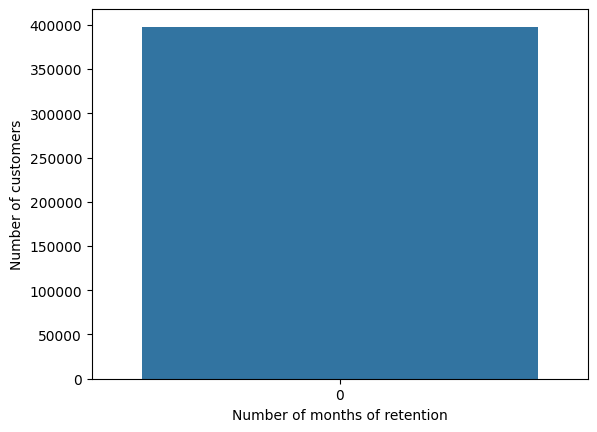

In [28]:
sns.countplot(data['MonthsRetained'])
plt.xlabel("Number of months of retention")
plt.ylabel("Number of customers")
plt.show()

Seperti yang bisa kita lihat, sebagian besar pelanggan hanya bertahan selama 1 bulan. 

Kita dapat melihat bahwa ada penurunan signifikan dalam jumlah pelanggan yang menggunakan produk di bulan berikutnya. dan setelah bulan itu, ada aliran pelanggan yang stabil untuk sisa tahun ini kecuali tahun depan di mana ada pelanggan yang kurang loyal. 

Hal ini dapat disebabkan oleh beberapa alasan:
1. Tidak ada penjualan atau diskon di akhir tahun.
2. Tidak ada penawaran musiman atau festival
(Hal ini dapat bervariasi dari satu negara ke negara lain)
3. Tidak ada pembaruan baru pada produk atau antarmuka toko.

Lebih dalam lagi, mari kita lihat tingkat retensi pelanggan berdasarkan kelompok.

In [29]:
group = data.groupby(['CohortMonthYear', 'MonthsRetained'])
cohorts = group['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohorts.pivot(index='CohortMonthYear', columns='MonthsRetained', values='CustomerID')
cohort_sizes = cohort_counts.iloc[:,0]
retention_percent = cohort_counts.divide(cohort_sizes, axis=0)*100

In [30]:
month_list = retention_percent.reset_index()['CohortMonthYear']

def get_month_name(x):
   return dt.datetime.strftime(x, '%b-%y')
  
month_list = month_list.apply(get_month_name)

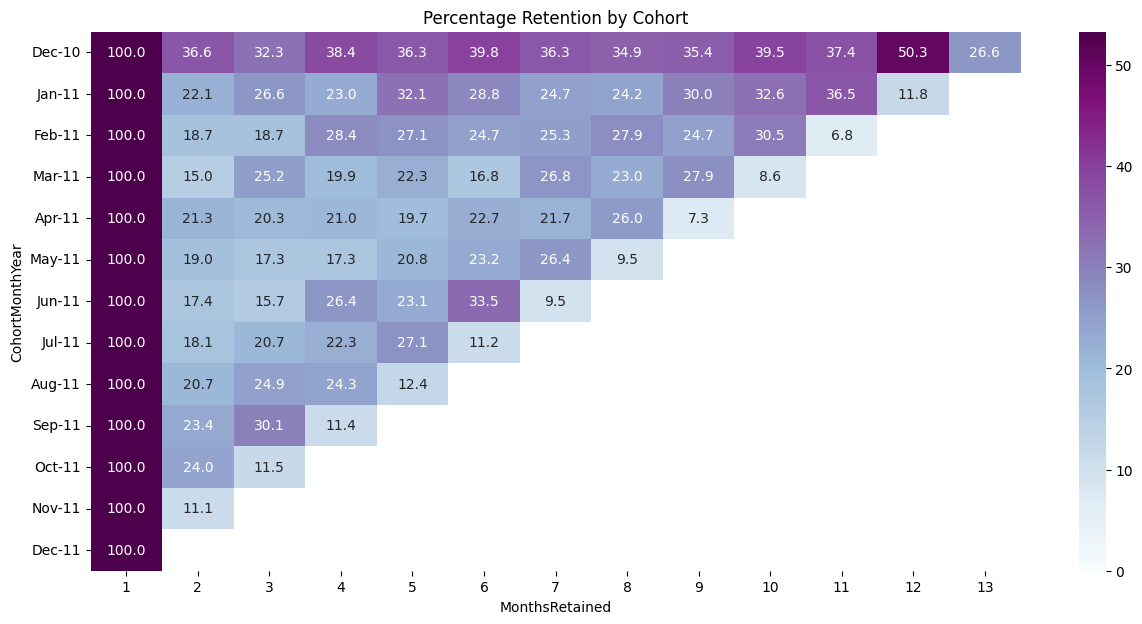

In [31]:

plt.figure(figsize=(15,7))
plt.title('Percentage Retention by Cohort')
sns.heatmap(data=retention_percent,annot = True,vmin = 0.0, cmap="BuPu",vmax = list(retention_percent.max().sort_values(ascending = False))[1]+3,fmt = '.1f',yticklabels=month_list)
plt.show()

Seperti yang dapat kita lihat, retensi pelanggan menunjukkan tren penurunan secara umum seiring berjalannya waktu.

Berdasarkan grafik analisis kohort dari Persentase Retensi kohort, kami menyimpulkan beberapa hal berikut:

1. Pelanggan yang membeli pertama kali pada bulan Desember 2010, terjadi penurunan yang signifikan dalam pembelian pelanggan pada 11 bulan berikutnya, namun pada akhir tahun pelanggan kembali membeli produk di toko dengan selisih yang sangat besar - Hal ini disebabkan oleh penjualan atau diskon akhir tahun yang dilakukan untuk menarik pelanggan baru dan lama untuk membeli yang mana hal ini merupakan solusi yang baik namun bersifat sementara untuk meningkatkan pendapatan. 

2. Selama bulan Mei hingga Agustus 2011, kita dapat melihat bahwa tingkat retensi meningkat setelah jeda. Untuk sebagian besar wilayah, tingkat retensi meningkat setelah 8 hingga 10 periode tetapi kemudian akhir tahun menurun. Peningkatan ini bisa jadi karena pemasaran email yang dilakukan dengan pelanggan lama yang memungkinkan mereka untuk kembali membeli produk, tetapi pada akhirnya, lebih sedikit pelanggan yang kembali karena tidak ada atau kurang komunikasi dengan toko. Toko harus memulai voucher diskon untuk pelanggan, yang melakukan pembelian setiap bulannya. Dengan cara ini, mereka akan dapat meningkatkan pendapatan mereka.

Q- Bagaimana perilaku belanja rata-rata dari setiap kelompok

In [32]:
gp=group['UnitPrice'].mean().reset_index()
average_price = gp.pivot(index='CohortMonthYear', columns='MonthsRetained', values='UnitPrice')
average_price.index = average_price.index.date

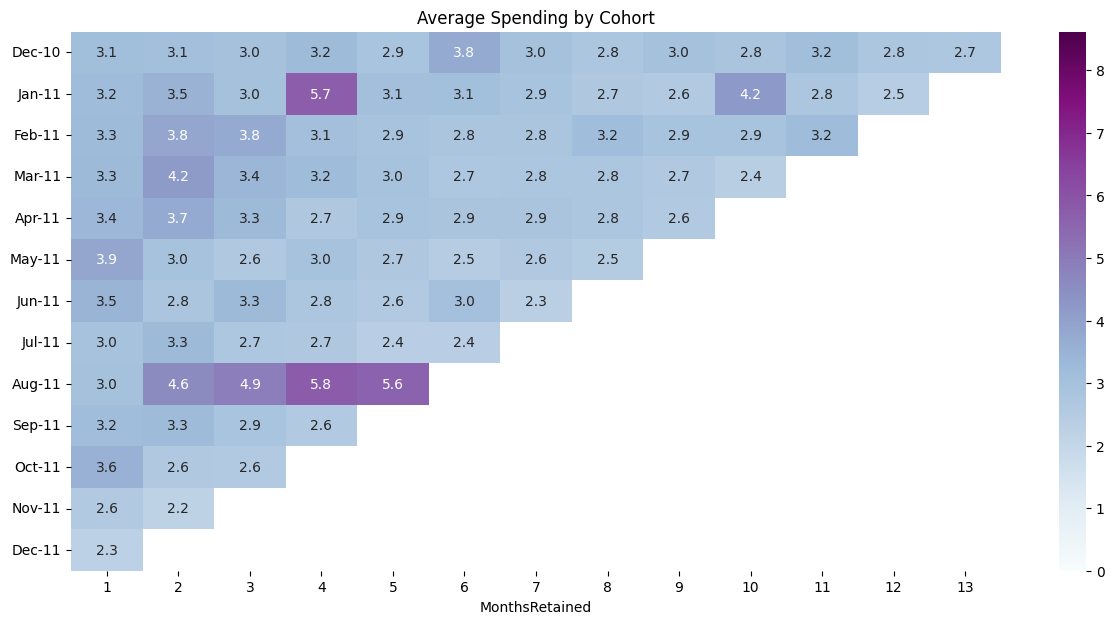

In [33]:
plt.figure(figsize=(15,7))
sns.heatmap(data = average_price,annot=True,vmin = 0.0, cmap="BuPu",vmax = list(average_price.max().sort_values(ascending = False))[1]+3,fmt = '.1f',yticklabels=month_list)
plt.title('Average Spending by Cohort')
plt.show()

Pengeluaran rata-rata setiap kelompok per bulan tetap stabil, dengan beberapa pengecualian.

T - Berapa jumlah rata-rata untuk setiap kelompok bulanan?

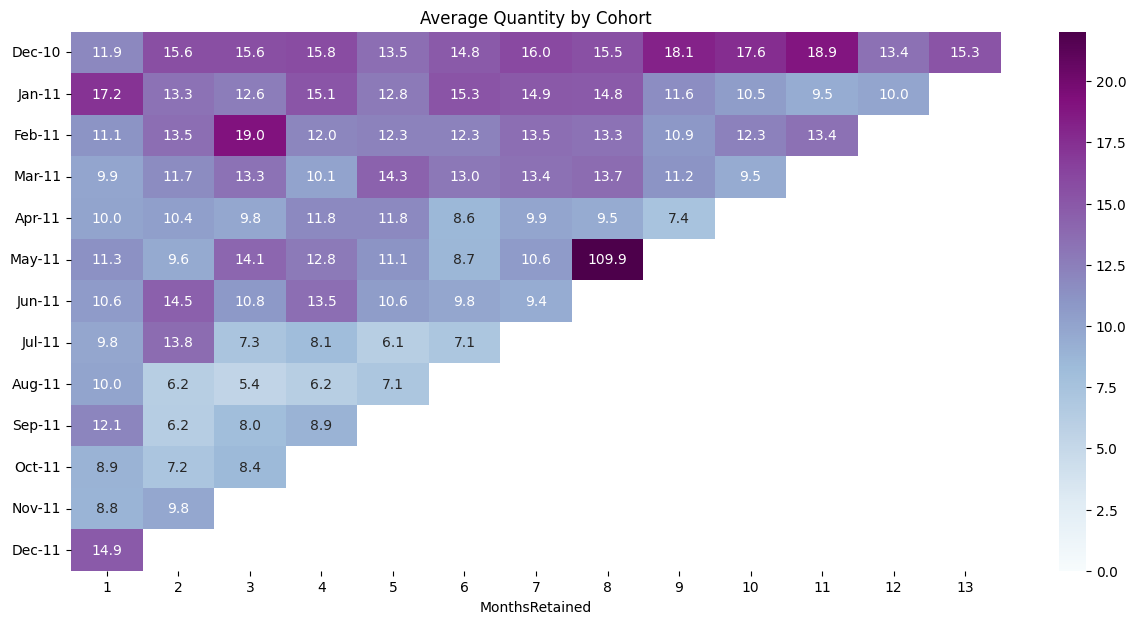

In [34]:
gp=group['Quantity'].mean().reset_index()
average_quantity = gp.pivot(index='CohortMonthYear', columns='MonthsRetained', values='Quantity')
average_quantity.index = average_quantity.index.date

plt.figure(figsize=(15,7))
sns.heatmap(data = average_quantity,annot=True,vmin = 0.0, cmap="BuPu",vmax = list(average_quantity.max().sort_values(ascending = False))[1]+3,fmt = '.1f',yticklabels=month_list)
plt.title('Average Quantity by Cohort')
plt.show()

Berdasarkan grafik di atas, kami melihat bahwa pada bulan Mei 2011, terjadi peningkatan jumlah penjualan yang signifikan di akhir tahun. Hal ini mungkin disebabkan oleh adanya clearance sale yang dilakukan oleh toko-toko yang memungkinkan mereka untuk menjual produk dengan harga murah untuk menghabiskan stok. Namun, dengan melihat grafik retensi kohort pada kohort yang sama di bulan Mei 2011, hal ini tidak meningkatkan jumlah pelanggan baru yang datang ke toko. Hal ini mungkin telah meningkatkan pendapatan tetapi mengorbankan kualitas produk yang pada gilirannya memiliki umpan balik negatif dari pelanggan setia.

Bagaimana tren retensi pelanggan di setiap negara?

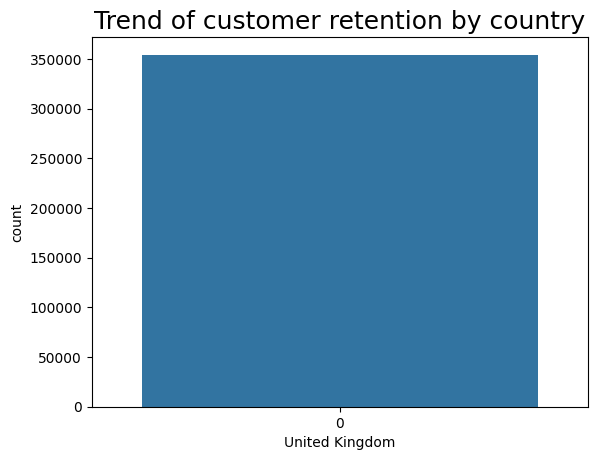

KeyError: ignored

In [35]:

plt.title("Trend of customer retention by country", fontsize=18, y=1)

for x in data['Country'].unique():
  data2=data[data['Country']==x]
  sns.countplot(data2['MonthsRetained'])
  plt.xlabel(x)
  plt.show()

Di sejumlah besar negara, kami mengamati bahwa retensi jauh lebih banyak dibandingkan dengan Inggris, namun dikalahkan oleh rendahnya jumlah pelanggan. Oleh karena itu, salah satu solusinya adalah dengan fokus pada peningkatan jangkauan perusahaan di pasar luar negeri, terutama yang memiliki tingkat gesekan yang rendah, seperti Belanda, Islandia, EIRE, Australia, dll.

Selain itu, harus ada fleksibilitas untuk memiliki kompatibilitas bahasa di toko online sehingga pelanggan di berbagai negara dapat menjalin hubungan jangka panjang dengan toko dan melakukan pembelian dengan mudah. Meningkatkan tingkat retensi pada saat yang bersamaan.

Pengamatan Utama:

1. Di EIRE, tidak ada kelompok yang terbentuk setelah Desember 2010. Hal ini menjadi perhatian utama. EIRE adalah pasar potensial terbesar keempat mereka. Selain itu, tingkat retensi EIRE lebih baik daripada bagian counterpart-nya yang mencapai hingga 100% setelah periode tertentu. Hal ini mengisyaratkan bahwa basis pelanggan EIRE sangat loyal. Toko e-commerce harus melakukan kampanye di EIRE untuk lebih memanfaatkan pasar potensial ini dan mendapatkan lebih banyak pelanggan setia, yang pada gilirannya meningkatkan pendapatan.

2. Pasar Inggris adalah basis pelanggan terbesar mereka. Namun, sebagian besar pengembalian juga berasal dari Inggris. Ini adalah situasi yang mengkhawatirkan. Toko harus lebih fokus pada kebutuhan dan keinginan basis pelanggan Inggris untuk meningkatkan pendapatan lebih jauh.

### Analisis matriks retensi berdasarkan negara
Seperti yang kami amati, orang-orang dari berbagai negara menjadi pelanggan. Mari kita lihat situasinya berdasarkan negara.

### UK

In [ ]:
# filtering records for UK only
dfUK = data[data['Country']=='United Kingdom']

# drop irrelevant columns and duplicate records
dfUK = dfUK[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

# order month
dfUK['order_month'] = dfUK['InvoiceDate'].dt.to_period('M')

# first purchase date for that customer
dfUK['cohort'] = dfUK.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M')

# a dataframe with cohort, order_month, n_customers, and period number
df_cohort = dfUK.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

# pivot the df_cohort
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

# calculate retention matrix
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)


# plot the retenton matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention in UK', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [ ]:
plt.plot(retention_matrix.mean())
plt.xlabel('# of periods')
plt.ylabel('retention rate')
plt.title('retention rate in the UK')

### Germany

In [ ]:
# filtering records for Germany only
dfGermany = data[data['Country']=='Germany']

# drop irrelevant columns and duplicate records
dfGermany = dfGermany[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

# order month
dfGermany['order_month'] = dfGermany['InvoiceDate'].dt.to_period('M')

# first purchase date for that customer
dfGermany['cohort'] = dfGermany.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M')

# a dataframe with cohort, order_month, n_customers, and period number
df_cohort = dfGermany.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)

df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

# pivot the df_cohort
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

# calculate retention matrix
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)


# plot the retenton matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention in Germany', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [ ]:
# plot retention rate
plt.plot(retention_matrix.mean())
plt.xlabel('# of periods')
plt.ylabel('retention rate')
plt.title('retention rate in Germany')

### Australia

In [ ]:
# filtering records for Australia only
dfAustralia = data[data['Country']=='Australia']

# drop irrelevant columns and duplicate records
dfAustralia = dfAustralia[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

# order month
dfAustralia['order_month'] = dfAustralia['InvoiceDate'].dt.to_period('M')

# first purchase date for that customer
dfAustralia['cohort'] = dfAustralia.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M')

# a dataframe with cohort, order_month, n_customers, and period number
df_cohort = dfAustralia.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)

df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

# pivot the df_cohort
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

# calculate retention matrix
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)


# plot the retenton matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention in Australia', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [ ]:
# plot retention rate
plt.plot(retention_matrix.mean())
plt.xlabel('# of periods')
plt.ylabel('retention rate')
plt.title('retention rate in Australia')

### Netherlands

In [ ]:
# filtering records for Netherlands only
dfNetherlands = data[data['Country']=='Netherlands']

# drop irrelevant columns and duplicate records
dfNetherlands = dfNetherlands[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

# order month
dfNetherlands['order_month'] = dfNetherlands['InvoiceDate'].dt.to_period('M')

# first purchase date for that customer
dfNetherlands['cohort'] = dfNetherlands.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M')

# a dataframe with cohort, order_month, n_customers, and period number
df_cohort = dfNetherlands.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)

df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

# pivot the df_cohort
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

# calculate retention matrix
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)


# plot the retenton matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention in Netherlands', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [ ]:
plt.plot(retention_matrix.mean())
plt.xlabel('# of periods')
plt.ylabel('retention rate')
plt.title('retention rate in the Netherlands')

### Iceland

In [ ]:
# filtering records for Iceland only
dfIceland = data[data['Country']=='Iceland']

# drop irrelevant columns and duplicate records
dfIceland = dfIceland[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

# order month
dfIceland['order_month'] = dfIceland['InvoiceDate'].dt.to_period('M')

# first purchase date for that customer
dfIceland['cohort'] = dfIceland.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M')

# a dataframe with cohort, order_month, n_customers, and period number
df_cohort = dfIceland.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)

df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

# pivot the df_cohort
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

# calculate retention matrix
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)


# plot the retenton matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention in Iceland', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [ ]:
plt.plot(retention_matrix.mean())
plt.xlabel('# of periods')
plt.ylabel('retention rate')
plt.title('retention rate in Iceland')

### EIRE

In [ ]:
# filtering records for EIRE only
dfEIRE = data[data['Country']=='EIRE']

# drop irrelevant columns and duplicate records
dfEIRE = dfEIRE[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

# order month
dfEIRE['order_month'] = dfEIRE['InvoiceDate'].dt.to_period('M')

# first purchase date for that customer
dfEIRE['cohort'] = dfEIRE.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M')

# a dataframe with cohort, order_month, n_customers, and period number
df_cohort = dfEIRE.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)

df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

# pivot the df_cohort
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

# calculate retention matrix
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)


# plot the retenton matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention in EIRE', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [ ]:
plt.plot(retention_matrix.mean())
plt.xlabel('# of periods')
plt.ylabel('retention rate')
plt.title('retention rate in EIRE')

## Customer Segmentation menggunakan RFM modeling

Sebelum kita dapat melanjutkan, kita membutuhkan tanggal patokan untuk menghitung recency, yaitu tanggal analisis. 
Recency = Tanggal Analisis - Tanggal Transaksi

untuk tujuan penyederhanaan, kita dapat mengasumsikan bahwa analisis dimulai 1 hari setelah transaksi terakhir.

In [ ]:
last_txn_date= data["InvoiceDate"].max()
analysis_date= last_txn_date + dt.timedelta(days = 1)

In [ ]:
rfm = data.groupby("CustomerID").agg({"InvoiceNo": [lambda Frequency: Frequency.nunique()],"TotalPrice": lambda TotalMoney: TotalMoney.sum(),"InvoiceDate": [lambda FinalOrder: (analysis_date - FinalOrder.max()).days]})
rfm.head()

In [ ]:
rfm = rfm.reset_index()
rfm

In [ ]:
rfm.columns = ["customer_id", "frequency", "monetary", "recency"]
rfm.head()

In [ ]:
len(rfm)

In [ ]:
rfm['R_score'] = rfm['recency'].rank(ascending=False)
rfm['F_score'] = rfm['frequency'].rank(ascending=True)
rfm['M_score'] = rfm['monetary'].rank(ascending=True)
 
# normalizing the rank of the customers
rfm['R_score_norm'] = (rfm['R_score']/rfm['R_score'].max())*100
rfm['F_score_norm'] = (rfm['F_score']/rfm['F_score'].max())*100
rfm['M_score_norm'] = (rfm['M_score']/rfm['M_score'].max())*100
 
rfm.drop(columns=['R_score', 'F_score', 'M_score'], inplace=True)
 
rfm.head()



Untuk skenario ini, kita dapat mempertimbangkan skor RFM sebagai rata-rata artimetrik dari Skor R, F, dan M untuk mempermudah, dengan mengasumsikan ketiganya memiliki tingkat kepentingan yang sama.

In [36]:
rfm['Final Score']= round((rfm['R_score_norm']+rfm['F_score_norm']+rfm['M_score_norm'])/3,2)
rfm.head()

NameError: ignored

In [ ]:
rfm['Segment']= rfm['Final Score'].apply(lambda x: 'Top Customer' if (x >=90) else ('High Value Customer' if (x >=75 and x<90) else('Medium Value Customer' if (x >=50 and x<75) else('Low Value Customer' if (x >=30 and x<50) else 'Lost Customer'))))
rfm.head()

In [ ]:
plt.figure(figsize=(15,7))
sns.countplot(rfm['Segment'])
plt.xlabel("Number of Customers by category")
plt.show()